In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Preparation
### Cleaning The Numbers data

In [3]:
df1 = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
# drop unnecssary columns: domestic_gross and id
df1.drop(['id', 'domestic_gross'], axis=1, inplace=True)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   worldwide_gross    5782 non-null   object
dtypes: object(4)
memory usage: 180.8+ KB


In [6]:
# define function to convert financials from object to int

def convert_to_int(v):
    df1[v] = df1[v].map(lambda x: x.replace(',',''))
    df1[v] = df1[v].map(lambda x: x.strip('$'))
    df1[v] = df1[v].astype('int64')

convert_to_int('production_budget')
convert_to_int('worldwide_gross')

In [7]:
df1.release_date = pd.to_datetime(df1.release_date)

In [8]:
df1.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,release_date,production_budget,worldwide_gross
count,5782.00,5782.00,5782.00
mean,.2f,31587757.10,91487460.91
min,.2f,1100.00,0.00
25%,.2f,5000000.00,4125414.75
50%,.2f,17000000.00,27984448.50
75%,.2f,40000000.00,97645836.50
max,.2f,425000000.00,2776345279.00
std,nan,41812076.83,174719968.78


In [9]:
# exploring the minimum we can see that the minimum worldwide_gross is 0
# given that there are no nulls, we will assume that 0 represents missing values and to avoid these numbers skewing the results, \
# we will remove them

missing_worldwide_gross = df1[df1.worldwide_gross == 0].index
df1.drop(missing_worldwide_gross, inplace=True)

In [10]:
# let's look at the date range - we can see from below that the earliest film included is 1915, and the latest is 2019
df1.release_date.describe()

count                             5415
mean     2004-02-20 12:26:11.634349056
min                1915-02-08 00:00:00
25%                1999-12-13 12:00:00
50%                2006-08-11 00:00:00
75%                2012-05-18 00:00:00
max                2019-06-21 00:00:00
Name: release_date, dtype: object

In [11]:
# given this data, let's look at the last decade available
df1 = df1[df1.release_date.dt.strftime('%Y') > '2008'].reset_index(drop=True)

In [12]:
# for consistency sake let's update the movie column heading and standardise the title
df1.rename(columns={'movie':'movie_title'}, inplace=True)
df1.movie_title = df1.movie_title.map(lambda x: x.title())

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       2140 non-null   datetime64[ns]
 1   movie_title        2140 non-null   object        
 2   production_budget  2140 non-null   int64         
 3   worldwide_gross    2140 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 67.0+ KB


In [438]:
# checking for duplicates in the movie title column
df1[df1.movie_title.duplicated()]

,release_date,movie_title,production_budget,worldwide_gross
268,2018-11-21,Robin Hood,99000000,84747441
1329,2015-08-14,Brothers,13000000,17856688
1960,2013-10-25,The Square,1500000,176262
2077,2009-04-23,Home,500000,44793168


Looking below, we can see that all four duplicates are legitimate entries. Based on the release date, they are different movies with the same name.

In [439]:
df1[df1.movie_title == 'Robin Hood']

,release_date,movie_title,production_budget,worldwide_gross
907,2009-12-04,Brothers,26000000,45043870
1329,2015-08-14,Brothers,13000000,17856688


In [440]:
df1[df1.movie_title == 'Brothers']

,release_date,movie_title,production_budget,worldwide_gross
907,2009-12-04,Brothers,26000000,45043870
1329,2015-08-14,Brothers,13000000,17856688


In [86]:
df1[df1.movie_title == 'The Square']

,release_date,movie_title,production_budget,worldwide_gross
5009,2010-04-09,The Square,1900000,740932
5099,2013-10-25,The Square,1500000,176262


In [278]:
df1[df1.movie_title == 'Home']

,release_date,movie_title,production_budget_mil,worldwide_gross_mil,global_profit_mil,roi,production_budget_tier
243,2015-03-27,Home,130.0,385.997896,255.997896,196.921458,High
5459,2009-04-23,Home,0.5,44.793168,44.293168,8858.633600,Low


So that we can distinguish between movies of the same name, I have appended the release year to the end of their movie_title.

In [441]:
movie_title_year_df1 = []

for i in range(len(df1.movie_title)):
    movie_title_year_df1.append(df1.movie_title[i] + f' ({df1.release_date.dt.year[i]})')

df1['movie_title'] = movie_title_year_df1

In [442]:
df1.head()

,release_date,movie_title,production_budget,worldwide_gross
0,2009-12-18,Avatar (2009),425000000,2776345279
1,2011-05-20,Pirates Of The Caribbean: On Stranger Tides (2...,410600000,1045663875
2,2019-06-07,Dark Phoenix (2019),350000000,149762350
3,2015-05-01,Avengers: Age Of Ultron (2015),330600000,1403013963
4,2017-12-15,Star Wars Ep. Viii: The Last Jedi (2017),317000000,1316721747


In [443]:
# converting financials in millions for readability
df1['production_budget_mil'] = df1.production_budget/1000000
df1['worldwide_gross_mil'] = df1.worldwide_gross/1000000

# dropping original production budget and worldwide gross to simplify table
df1.drop(['production_budget', 'worldwide_gross'], axis=1, inplace=True)

# calculating the global profit in millions and ROI
df1['global_profit_mil'] = df1['worldwide_gross_mil'] - df1['production_budget_mil']
df1['roi'] = (df1.global_profit_mil/df1.production_budget_mil)*100

Binning budgets - 

We are going to use Studiobinder's definition of budget tiers (https://www.studiobinder.com/blog/production-budget/): 

* Low budget (these are usually financed through self-financing or small private funding): 5 million and below
* Mid-level (usually financed by a studio): 5-50 million
* High-budget (almost always financed by a film studio): more than 50 million

In [444]:
# let's bin the budgets 
df1['production_budget_tier'] = pd.cut(df1['production_budget_mil'], bins=[0, 5, 50, np.inf], labels=['Low', 'Medium', 'High'])

In [445]:
df1.head()

,release_date,movie_title,production_budget_mil,worldwide_gross_mil,global_profit_mil,roi,production_budget_tier
0,2009-12-18,Avatar (2009),425.0,2776.345279,2351.345279,553.257713,High
1,2011-05-20,Pirates Of The Caribbean: On Stranger Tides (2...,410.6,1045.663875,635.063875,154.667286,High
2,2019-06-07,Dark Phoenix (2019),350.0,149.762350,-200.237650,-57.210757,High
3,2015-05-01,Avengers: Age Of Ultron (2015),330.6,1403.013963,1072.413963,324.384139,High
4,2017-12-15,Star Wars Ep. Viii: The Last Jedi (2017),317.0,1316.721747,999.721747,315.369636,High


### Cleaning The Movie Data Base dataset

In [529]:
df2 = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
df2.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [530]:
df2.original_language.unique()

array(['en', 'nl', 'es', 'ja', 'sv', 'de', 'fr', 'cn', 'it', 'ru', 'zh',
       'hi', 'no', 'ko', 'da', 'fi', 'pl', 'te', 'hu', 'tr', 'pt', 'he',
       'fa', 'th', 'cs', 'et', 'tl', 'lt', 'xx', 'bs', 'ar', 'is', 'el',
       'mr', 'hr', 'ro', 'sr', 'uk', 'nb', 'hz', 'ca', 'bg', 'sl', 'lv',
       'si', 'ab', 'ta', 'bo', 'id', 'sq', 'bn', 'gu', 'lo', 'ne', 'kk',
       'hy', 'ps', 'kn', 'vi', 'ku', 'ka', 'ml', 'ur', 'mi', 'eu', 'sn',
       'cy', 'ha', 'ky', 'yi', 'pa', 'xh', 'cr', 'sw', 'af', 'dz'],
      dtype=object)

In [531]:
# let's focus on english movies for now
df2 = df2[df2.original_language == 'en']

In [532]:
# let's drop unnamed, id, original_title, and popularity
df2.drop(['Unnamed: 0', 'id', 'original_title', 'popularity', 'original_language'], axis=1, inplace=True)

In [533]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23291 entries, 0 to 26516
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genre_ids     23291 non-null  object 
 1   release_date  23291 non-null  object 
 2   title         23291 non-null  object 
 3   vote_average  23291 non-null  float64
 4   vote_count    23291 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [534]:
df2.release_date = pd.to_datetime(df2.release_date)

In [535]:
df2.describe()

,release_date,vote_average,vote_count
count,23291,23291.000000,23291.000000
mean,2014-06-30 21:08:44.442917888,5.953458,209.307887
min,1930-04-29 00:00:00,0.000000,1.000000
25%,2012-07-27 00:00:00,5.000000,1.000000
50%,2014-10-05 00:00:00,6.000000,4.000000
75%,2016-10-09 12:00:00,7.000000,24.000000
max,2020-12-25 00:00:00,10.000000,22186.000000
std,NaN,1.897055,1016.214512


In [536]:
# so that we are looking at the same year frame, let's filter by year 2009-2019
df2 = df2[df2.release_date.dt.strftime('%Y') > '2008']

# we can see that max date included 2020, so let's check those rows 

df2[df2.release_date.dt.strftime('%Y') == '2020']

,genre_ids,release_date,title,vote_average,vote_count
26057,"[27, 80, 80, 80, 80, 80, 80]",2020-12-25,Murdery Christmas,0.0,1


In [537]:
# There is only one entry with no vote counts. Let's filter vote counts, which will get rid of this entry as well
# we can see that the majority of vote_counts lie between 1-27. The low vote count may not provide an accurate depiction of movie success \
# as vote_average may be inflated due to the particular movie being catered to a niche audience

df2 = df2[df2.vote_count > 27]

In [538]:
# rename title to movie_title for consistency 
df2.rename(columns={'title':'movie_title'}, inplace=True)
df2.movie_title = df2.movie_title.map(lambda x: x.title())

# looking for duplicates and removing these while resetting the index
df2 = df2.drop_duplicates().reset_index(drop=True)

In [539]:
# so that the movie title is standardised with df1
movie_title_year_df2 = []

for i in range(len(df2.movie_title)):
    movie_title_year_df2.append(df2.movie_title[i] + f' ({df2.release_date.dt.year[i]})')

df2['movie_title'] = movie_title_year_df2

In [540]:
# checking for duplicates
df2[df2.movie_title.duplicated()]

,genre_ids,release_date,movie_title,vote_average,vote_count
1974,"[27, 53]",2013-07-19,Beneath (2013),3.8,38
3237,"[53, 18]",2015-09-18,Eden (2015),5.4,29


Let's check these duplicates; are they distinct movies?

In [541]:
df2[df2.movie_title == 'Beneath (2013)']

,genre_ids,release_date,movie_title,vote_average,vote_count
1666,[27],2013-10-08,Beneath (2013),5.2,76
1974,"[27, 53]",2013-07-19,Beneath (2013),3.8,38


In [542]:
df2[df2.movie_title == 'Eden (2015)']

,genre_ids,release_date,movie_title,vote_average,vote_count
2455,"[18, 10402]",2015-06-19,Eden (2015),5.8,57
3237,"[53, 18]",2015-09-18,Eden (2015),5.4,29


In [543]:
# decided to keep the first of the movies as they have a higher vote_count
df2.drop_duplicates(subset='movie_title', inplace=True)

In [544]:
df2.head()

,genre_ids,release_date,movie_title,vote_average,vote_count
0,"[12, 14, 10751]",2010-11-19,Harry Potter And The Deathly Hallows: Part 1 (...,7.7,10788
1,"[14, 12, 16, 10751]",2010-03-26,How To Train Your Dragon (2010),7.7,7610
2,"[12, 28, 878]",2010-05-07,Iron Man 2 (2010),6.8,12368
3,"[28, 878, 12]",2010-07-16,Inception (2010),8.3,22186
4,"[12, 14, 10751]",2010-02-11,Percy Jackson & The Olympians: The Lightning T...,6.1,4229


In [545]:
# we can see that while genre_ids appears to look like a list, it is actually a string with brackets
df2.genre_ids[0][0]

'['

In [546]:
df2['genre_ids'] = df2.genre_ids.map(lambda x: x.strip('[ ]'))
df2['genre_ids'] = df2.genre_ids.map(lambda x: x.split(', '))

# converting from set back to list to ensure that there are no duplicates of genre per row
df2.genre_ids = df2.genre_ids.map(lambda x: list(set(x)))

In [547]:
# note that the order will now be different as set does not maintain order
df2.genre_ids[0][0]

'14'

In [553]:
df2.drop(['release_date'], axis=1, inplace=True)

In [557]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5019 entries, 0 to 5020
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genre_ids     5019 non-null   object 
 1   movie_title   5019 non-null   object 
 2   vote_average  5019 non-null   float64
 3   vote_count    5019 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 325.1+ KB


In [554]:
# joining df2 with df1 to combine The Numbers data with The Movie Database data

df3 = df1.merge(df2, on='movie_title', how='inner')

In [555]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   release_date            1392 non-null   datetime64[ns]
 1   movie_title             1392 non-null   object        
 2   production_budget_mil   1392 non-null   float64       
 3   worldwide_gross_mil     1392 non-null   float64       
 4   global_profit_mil       1392 non-null   float64       
 5   roi                     1392 non-null   float64       
 6   production_budget_tier  1392 non-null   category      
 7   genre_ids               1392 non-null   object        
 8   vote_average            1392 non-null   float64       
 9   vote_count              1392 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 99.5+ KB


In [556]:
df3.head()

,release_date,movie_title,production_budget_mil,worldwide_gross_mil,global_profit_mil,roi,production_budget_tier,genre_ids,vote_average,vote_count
0,2009-12-18,Avatar (2009),425.0,2776.345279,2351.345279,553.257713,High,"[878, 14, 12, 28]",7.4,18676
1,2011-05-20,Pirates Of The Caribbean: On Stranger Tides (2...,410.6,1045.663875,635.063875,154.667286,High,"[14, 12, 28]",6.4,8571
2,2015-05-01,Avengers: Age Of Ultron (2015),330.6,1403.013963,1072.413963,324.384139,High,"[878, 12, 28]",7.3,13457
3,2018-04-27,Avengers: Infinity War (2018),300.0,2048.134200,1748.134200,582.711400,High,"[14, 12, 28]",8.3,13948
4,2017-11-17,Justice League (2017),300.0,655.945209,355.945209,118.648403,High,"[878, 14, 12, 28]",6.2,7510


### Cleaning and joining IMDb

In [6]:
df4 = pd.read_csv('./zippedData/imdb_basics.aug23_reduced.csv.gz')
df4.head()

,Unnamed: 0,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres
0,0,tt0013274,movie,Istoriya grazhdanskoy voyny,2021,94,Documentary
1,1,tt0052434,movie,"Tuppe tuppe, Marescià!",2023,95,Comedy
2,2,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,70,Drama
3,3,tt0068865,movie,Lives of Performers,2016,90,Drama
4,4,tt0069049,movie,The Other Side of the Wind,2018,122,Drama


In [7]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210566 entries, 0 to 210565
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      210566 non-null  int64 
 1   tconst          210566 non-null  object
 2   titleType       210566 non-null  object
 3   primaryTitle    210566 non-null  object
 4   startYear       210566 non-null  int64 
 5   runtimeMinutes  210566 non-null  int64 
 6   genres          210566 non-null  object
dtypes: int64(3), object(4)
memory usage: 11.2+ MB


In [8]:
# drop unnamed column
df4.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
# confirm no nulls
df4.replace(r'\N', np.nan, inplace=True)
df4.isna().sum()

tconst            0
titleType         0
primaryTitle      0
startYear         0
runtimeMinutes    0
genres            0
dtype: int64

In [13]:
# remove 2023 as not enough data yet
df4 = df4[df4.startYear < 2023]

In [14]:
df4['runtimeMinutes'] = df4['runtimeMinutes'].astype('int64')

In [15]:
df5 = pd.read_csv('./zippedData/title.ratings.aug23.tsv.gz', sep='\t')
df5.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1990
1,tt0000002,5.8,265
2,tt0000003,6.5,1854
3,tt0000004,5.5,178
4,tt0000005,6.2,2640


In [17]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335975 entries, 0 to 1335974
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1335975 non-null  object 
 1   averageRating  1335975 non-null  float64
 2   numVotes       1335975 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 30.6+ MB


In [18]:
# replace all \N with NaNs so we can can get an accurate sense of nulls
df5.replace(r'\N', np.nan, inplace=True)

In [19]:
df5.isna().any()

tconst           False
averageRating    False
numVotes         False
dtype: bool

In [20]:
# set the index of df5 and df6 so that we can join
df4.set_index('tconst', inplace=True)
df5.set_index('tconst', inplace=True)

In [21]:
df_imdb_final = df4.join(df5, how='inner')
df_imdb_final.head()

,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,
tt0013274,movie,Istoriya grazhdanskoy voyny,2021,94,Documentary,6.8,57
tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,70,Drama,6.4,176
tt0068865,movie,Lives of Performers,2016,90,Drama,5.4,75
tt0069049,movie,The Other Side of the Wind,2018,122,Drama,6.7,7777
tt0096235,movie,Taxi Killer,2022,106,"Action,Crime,Drama",5.9,63


In [22]:
df_imdb_final.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,startYear,runtimeMinutes,averageRating,numVotes
count,126061.00,126061.00,126061.00,126061.00
mean,2015.74,92.92,6.27,3794.75
std,3.87,197.85,1.46,34325.73
min,2009.00,1.00,1.00,5.00
25%,2013.00,80.00,5.40,20.00
50%,2016.00,90.00,6.40,75.00
75%,2019.00,103.00,7.30,406.00
max,2022.00,51420.00,10.00,2446691.00


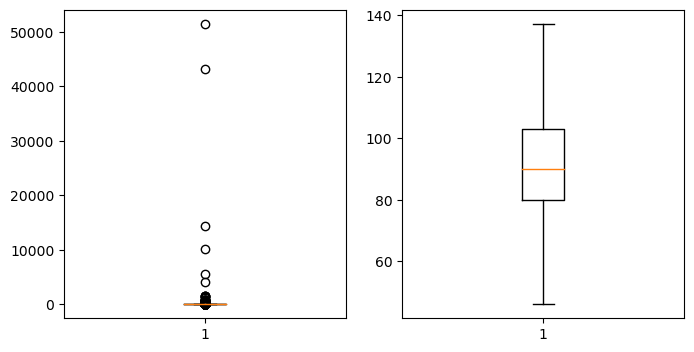

In [23]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].boxplot(df_imdb_final['runtimeMinutes'])
axes[1].boxplot(df_imdb_final['runtimeMinutes'], showfliers=False);

We can see that there a few outliers skewing runtimeMinutes data. For the sake of regular distribution, we will be focusing on movies less than 300 minutes (5 hours).

In [24]:
df_imdb_final = df_imdb_final[df_imdb_final.runtimeMinutes < 300]

In [25]:
# let's bin the runtime_minutes data
df_imdb_final['runtimeMinutes_binned'] = pd.cut(df_imdb_final['runtimeMinutes'], \
       bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300], \
       labels=['< 30', '30-60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-240', '240-270', '270+'])

In [26]:
df_imdb_final.head()

,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,runtimeMinutes_binned
tconst,,,,,,,,
tt0013274,movie,Istoriya grazhdanskoy voyny,2021,94,Documentary,6.8,57,90-120
tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,70,Drama,6.4,176,60-90
tt0068865,movie,Lives of Performers,2016,90,Drama,5.4,75,60-90
tt0069049,movie,The Other Side of the Wind,2018,122,Drama,6.7,7777,120-150
tt0096235,movie,Taxi Killer,2022,106,"Action,Crime,Drama",5.9,63,90-120


### Data Analysis: The Numbers data

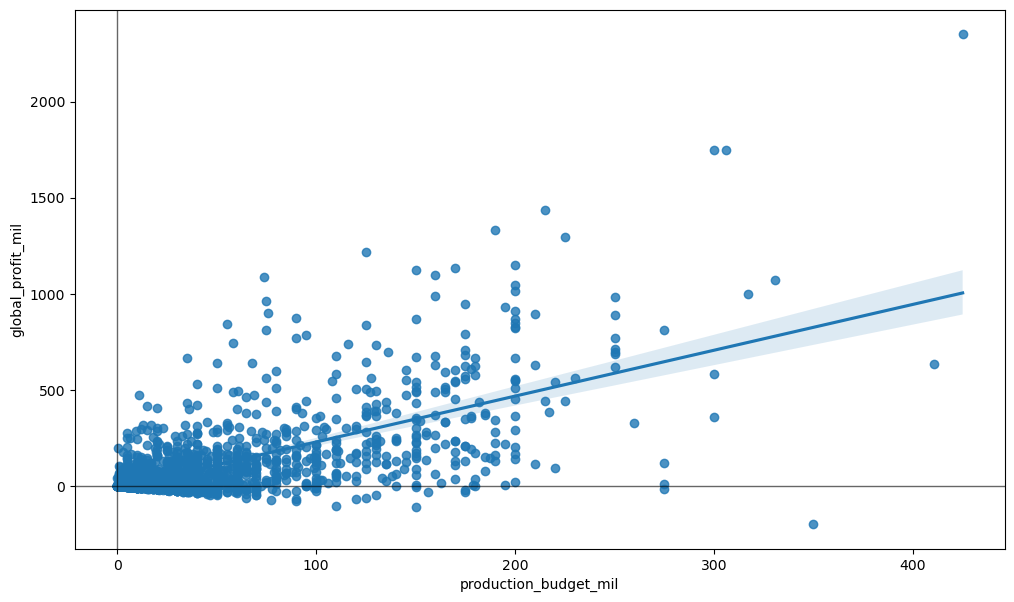

In [91]:
fig, ax = plt.subplots(figsize=(12,7))

sns.regplot(x='production_budget_mil', y='global_profit_mil', data=df1)
plt.axvline(0, color='black', linewidth=1, alpha=0.6)
plt.axhline(0, color='black', linewidth=1, alpha=0.6);

In [92]:
corr_budget_profit = np.corrcoef(df1.production_budget_mil, df1.global_profit_mil)[0,1] 
print(f'Calculated Pearson Correlation (r) between production budget and global profit is: \
{"{0:.2f}".format(corr_budget_profit)}')

Calculated Pearson Correlation (r) between production budget and global profit is: 0.68


Now that we've established there is a moderate relationship between production budget and global profit, let's take a look at ROI to see whether a certain budget group correlates with a higher % of ROI?

In [140]:
groupedby_budget = df1.groupby(df1.production_budget_tier).median(numeric_only=True)
groupedby_budget.columns = [col + '_median' for col in groupedby_budget.columns]
groupedby_budget['count_of_movies'] = df1.groupby(df1.production_budget_tier)['movie_title'].count()
groupedby_budget.reset_index(inplace=True)
groupedby_budget

,production_budget_tier,production_budget_mil_median,worldwide_gross_mil_median,global_profit_mil_median,roi_median,count_of_movies
0,Low,2.0,1.577585,0.088390,7.009267,459
1,Medium,20.0,36.588512,14.551283,80.738155,1183
2,High,100.0,276.471539,160.845456,162.844521,498


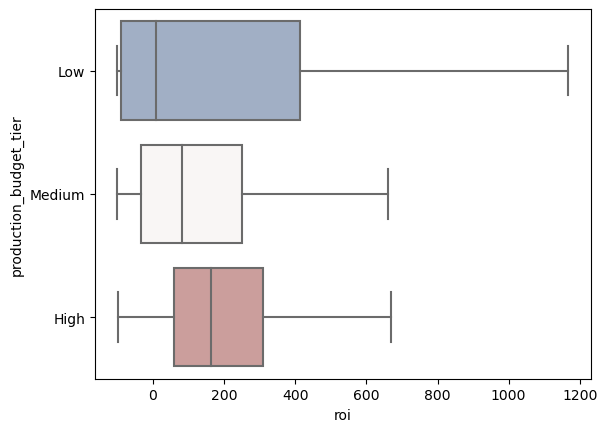

In [163]:
fig, axes = plt.subplots()
sns.boxplot(x=df1.roi, y=df1.production_budget_tier, showfliers=False, palette='vlag');

We can see that a high production budget sees the highest median ROI, with the median ROI of a high budget film more than double that of a medium budget film. High production budget = higher ROI.

However, low budget films see the greatest IQR and variability of distribution. Grounds for further investigation.

Some food for thought, does the release month have a relationship on ROI? Are there certain seasons where people are watching more movies?

In [94]:
groupedby_month = df1.groupby(df1.release_date.dt.month).median(numeric_only=True)
groupedby_month.columns = [col + '_median' for col in groupedby_month.columns]
groupedby_month['count_of_movies'] = df1.groupby(df1.release_date.dt.month)['movie_title'].count()
groupedby_month.reset_index(inplace=True)
groupedby_month

,release_date,production_budget_mil_median,worldwide_gross_mil_median,global_profit_mil_median,roi_median,count_of_movies
0,1,23.0,48.437072,19.780530,112.033036,142
1,2,26.5,51.392713,22.200023,116.267777,156
2,3,20.0,36.715516,14.953905,89.926215,182
3,4,17.0,23.910210,6.594052,52.339267,189
4,5,25.0,58.329674,30.621358,118.073048,158
5,6,23.0,46.844357,16.438538,113.521460,169
6,7,20.0,75.898100,35.098356,171.157560,163
7,8,20.0,43.833393,19.603817,90.882113,178
8,9,16.0,31.943401,12.141617,80.583507,193
9,10,14.0,18.889972,4.109597,48.194236,211


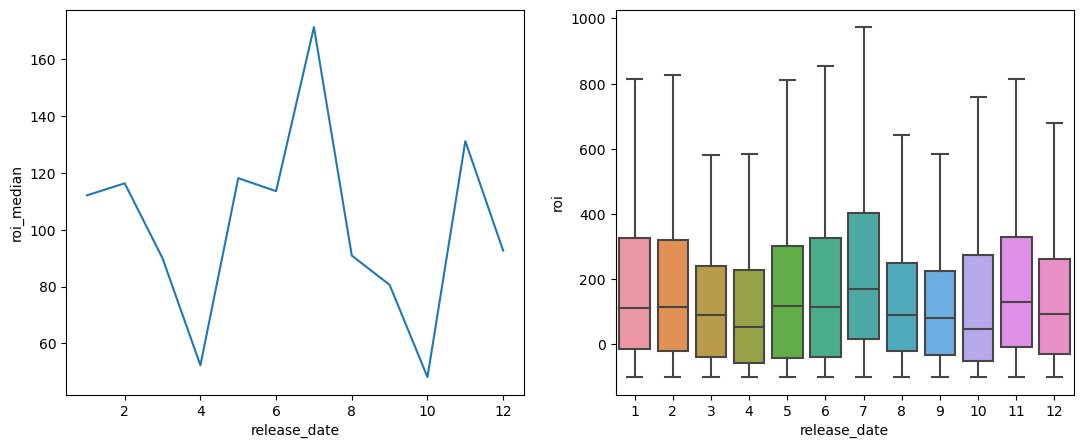

In [95]:
# using median as it is more robust given the outliers, we can see that ROI tends to be highest during the summer months of the northern
# hemisphere, as well as the holiday season and Valentine's Day. Let's see the impact of genre.

fig, axes = plt.subplots(1,2,figsize=(13,5))
sns.lineplot(x=groupedby_month.release_date, y=groupedby_month.roi_median, ax=axes[0])
sns.boxplot(x=df1.release_date.dt.month, y=df1.roi, showfliers=False, ax=axes[1]);

From the above we can see that there is a moderately positive correlation between budget and worldwide profit. However, there is quite a bit of variety so we will examine whether genre impacts profitability. 

Furthermore we can see that ROI tends to be higher during summer months (northern hemisphere) and towards the holiday season. We see an increase in February, potentially due to Valentine's Day. We will investigate whether genre also has an impact.

### Which genres are more profitable? Looking at The Numbers combined with TMDB data

### Looking at the relationship between runtime and average rating

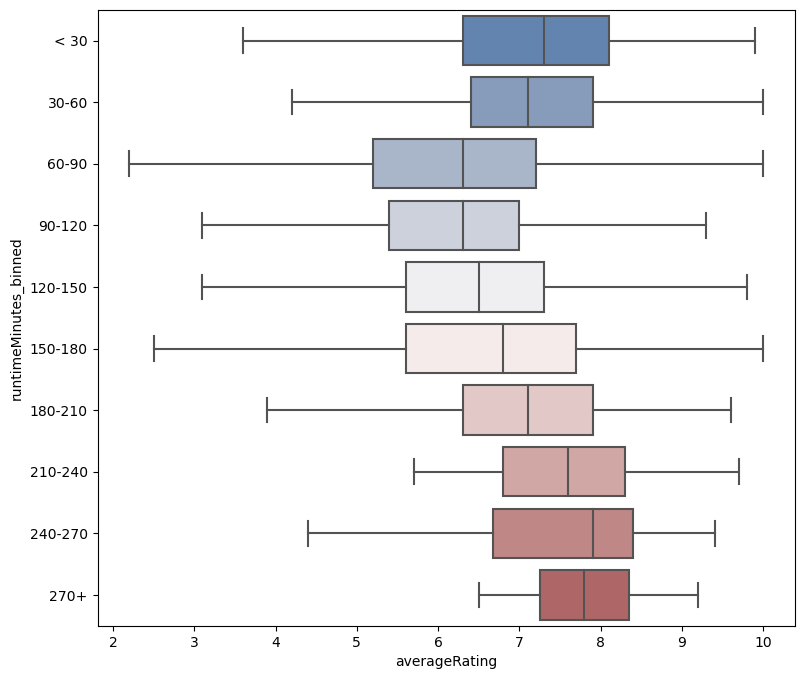

In [27]:
fig, ax = plt.subplots(figsize=(9,8))
sns.boxplot(x='averageRating', y='runtimeMinutes_binned', data=df_imdb_final, showfliers=False, palette="vlag");

We can see that as the runtime increases, so does the median averageRating, suggesting that the longer a movie is, the more highly rated it is. However it is consider the number of votes per movie.

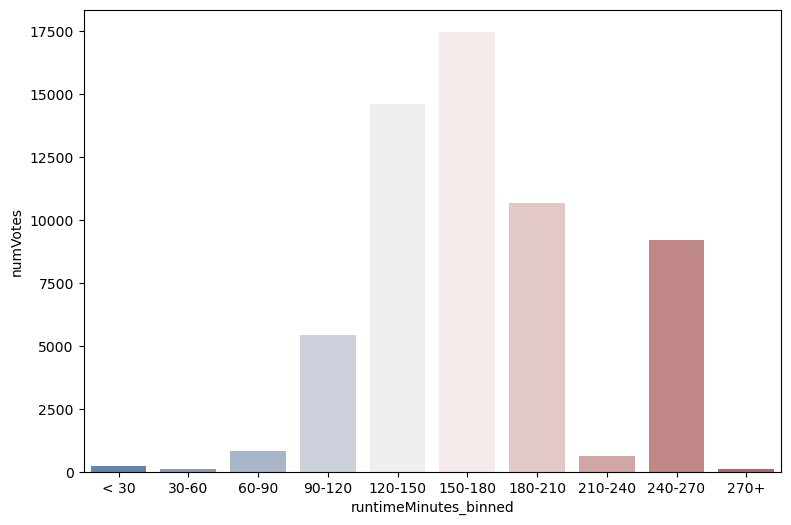

In [28]:
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=df_imdb_final, x='runtimeMinutes_binned', y='numVotes', palette="vlag", errorbar=None);

We can see that while <30 and 30-60 scored highly on average, the average number of votes for these movies is significantly lower than that of 120-150, 150-180, and 180-210. This suggests that these movies appeal to less audiences and may not be suitable for global commerical success.

### Limitations

In [29]:
grouped = df_imdb_final.groupby(['startYear']).count().reset_index()
grouped.head()

,startYear,titleType,primaryTitle,runtimeMinutes,genres,averageRating,numVotes,runtimeMinutes_binned
0,2009,7178,7178,7178,7178,7178,7178,7178
1,2010,7486,7486,7486,7486,7486,7486,7486
2,2011,8091,8091,8091,8091,8091,8091,8091
3,2012,8424,8424,8424,8424,8424,8424,8424
4,2013,8839,8839,8839,8839,8839,8839,8839


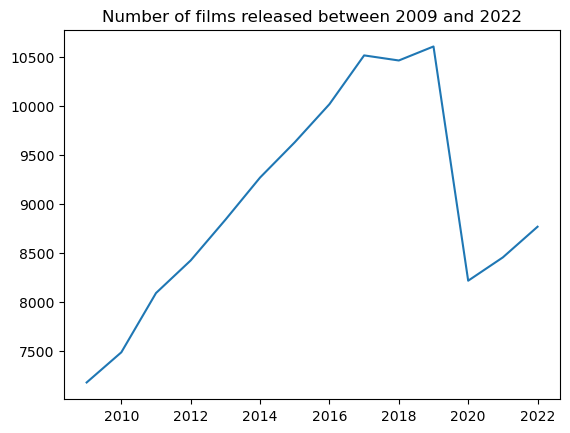

In [30]:
fig, ax = plt.subplots()
ax.plot(grouped['startYear'], grouped['primaryTitle'])
ax.set_title('Number of films released between 2009 and 2022');

# add labels for when Netflix was introduced, other streaming sites came into the scene and COVID